In [28]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn
import seaborn as sn
import datetime
import random
from datetime import date
from pprint import pprint
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer
import statistics 
from statistics import mode
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier

In [29]:
def convert_strings_to_dates(dataframe, testset=False):
    frame = dataframe.copy()
    if testset:
        frame.dt = [date.fromisoformat(d) for d in frame.dt]
        frame.first_load_date = [date.fromisoformat(d) for d in frame.first_load_date]
        frame.ts_signup = [datetime.datetime.strptime(d, '%Y-%m-%d %H:%M:%S+00:00') for d in frame.ts_signup]
        frame.ts_signup = [date(year=d.year, month=d.month, day=d.day) for d in frame.ts_signup]
    else:
        frame.dt = [date.fromisoformat(d) for d in frame.dt]
        frame.first_load_date = [date.fromisoformat(d) for d in frame.first_load_date]
        frame.most_recent_load_date = [date.fromisoformat(d) for d in frame.most_recent_load_date]
        frame.ts_signup = [datetime.datetime.strptime(d, '%Y-%m-%d %H:%M:%S+00:00') for d in frame.ts_signup]
        frame.ts_signup = [date(year=d.year, month=d.month, day=d.day) for d in frame.ts_signup]
    return frame

In [30]:
def convert_date_to_int(dataframe, columns):
    frame = dataframe.copy()
    conversion = lambda dt_time: 10000*dt_time.year + 100*dt_time.month + dt_time.day
    
    for col in columns:
        frame[f'{col}'] = [conversion(d) for d in frame[f'{col}']]

    return frame

In [31]:
def aggregate_rows_by_driver_id(dataframe):
    '''
    Returns a new dataframe indexed by Driver ID using an optimal set of aggregations per column.
    This method will return a dataframe that only contains the columns listed below.
    Note: duplicate columns are inherently pruned (simply by not adding them below), so it is 
        safe to pass in the full dataframe and expect a pruned version in return. 
        Also note that the `id_driver` will now be the index of the dataframe and NOT its own column.
    '''
    minimum = 'min'
    maximum = 'max'
    median = 'median'
    random_mode = lambda x: random.choice(pd.Series.mode(x if isinstance(x, list) else list(x)))
    average = lambda x: pd.Series.mean(x)

    aggregation = {
        'dt': maximum,
        'weekday': random_mode,
        'dim_carrier_type': random_mode,
        'carrier_trucks': mode,
        'num_trucks': maximum,
        'interested_in_drayage': random_mode,
        'port_qualified': random_mode,
        'signup_source': random_mode,
        'ts_signup': maximum,
        'days_signup_to_approval': maximum,
        'driver_with_twic': mode,
        'dim_preferred_lanes': mode,
        'first_load_date': minimum,
        'loads': random_mode,
        'marketplace_loads_otr': maximum,
        'marketplace_loads_atlas': maximum,
        'marketplace_loads': maximum,
        'brokerage_loads_otr': maximum,
        'brokerage_loads_atlas': maximum,
        'brokerage_loads': maximum,
        'label': random_mode
    }

    return dataframe.groupby(['id_driver']).agg(aggregation)

In [32]:
def augment_boolean_columns(dataframe):
    frame = dataframe.copy()
    label_encoder = LabelEncoder()
    
    # Replacement (no new columns needed, just transform strings to 0 or 1)
    frame['interested_in_drayage'] = label_encoder.fit_transform(frame.interested_in_drayage)
    frame['port_qualified'] = label_encoder.fit_transform(frame.port_qualified)
    frame['driver_with_twic'] = label_encoder.fit_transform(frame.driver_with_twic)
    
    # Create new columns with more appropriate names, delete the old columns
    frame['self_owned'] = label_encoder.fit_transform(frame.dim_carrier_type)
    frame['mobile_signup'] = np.logical_xor(label_encoder.fit_transform(frame.signup_source), 1).astype(int)
    frame['has_route_preference'] = label_encoder.fit_transform(~frame.dim_preferred_lanes.isnull())
    frame.drop(columns=['dim_carrier_type', 'signup_source', 'dim_preferred_lanes'], inplace=True)
    
    return frame

In [33]:
def encode_categorical_columns(dataframe):
    frame = dataframe.copy()

    # Encode various truck types
    trucks = pd.get_dummies(frame.carrier_trucks)
    trucks.columns = ['truck-' + c.replace('[', '').replace(']', '').replace('"', '').replace(',', '').replace(' ', '-') for c in trucks.columns]
    
    # Encode the 7 different days of the week
    weekdays = pd.get_dummies(frame.weekday)
    weekdays.columns = [f'prefers-{x}'.lower() for x in weekdays.columns]
    
    # Drop the originals since they are no longer needed.
    frame.drop(columns=['carrier_trucks', 'weekday'], inplace=True)
    
    # Concatenate various new frames with the original and return
    result = pd.concat([frame, trucks, weekdays], axis=1)
    return result

In [34]:
def standardize_numericals(dataframe, columns=None):    
    scaler = StandardScaler()
    frame = None
    
    if columns:
        frame = dataframe[columns].copy()
    else:
        frame = dataframe.copy()
    
    x = scaler.fit_transform(frame)
    scaled_df = pd.DataFrame(x)
    scaled_df.columns = frame.columns

    
    if columns:
        frame = dataframe.copy()
        frame[columns] = scaled_df.values
    else:
        frame = scaled_df.copy()
    
    return frame

In [35]:
def impute_numericals(dataframe, columns, strategy='most_frequent', testset=False):
    frame = dataframe.copy()
    imp = SimpleImputer(missing_values=np.nan, strategy=strategy)
    
    for col in columns:
        imp.fit(frame[f'{col}'].values.reshape(-1, 1))
        frame[f'{col}'] = imp.transform(frame[f'{col}'].values.reshape(-1, 1))
    
    return frame

In [36]:
def generate_labels(dataframe, loads_percentile, most_recent_percentile):
    label_encoder = LabelEncoder()
    frame = dataframe.copy()
    
    labels = (frame.total_loads >= loads_percentile) & (frame.most_recent_load_date >= most_recent_percentile)
    frame['label'] = label_encoder.fit_transform(labels)
    frame.drop(columns=['total_loads', 'most_recent_load_date'], inplace=True)
    
    return frame

In [37]:
def get_Xy(dataframe, aggregate=False, standardize=False, testdata=False):
    frame = dataframe.copy()
    scaler = StandardScaler()
    loads_75th_percentile = 17
    most_recent_75th_percentile = date(year=2021, month=2, day=10)


    if testdata:
        frame = convert_strings_to_dates(frame, testset=True)
        frame = augment_boolean_columns(frame)
        frame = encode_categorical_columns(frame)
        frame = convert_date_to_int(frame, columns=['dt', 'ts_signup', 'first_load_date'])

        # The only columns not in the new frame should be booleans that are safely set to 0
        for col in dataframe.columns:
            if col not in frame.columns:
                frame[f'{col}'] = 0

        frame.drop(columns=['weekday'], inplace=True)
        frame = impute_numericals(frame, ['days_signup_to_approval'])

        if standardize:
            frame = standardize_numericals(frame)

        frame.sort_index(axis=1, inplace=True)
        return frame, None
    
    
    frame = convert_strings_to_dates(frame)
    
    if aggregate:
        frame = generate_labels(frame, loads_75th_percentile, most_recent_75th_percentile)
        frame = aggregate_rows_by_driver_id(frame)
        frame = augment_boolean_columns(frame)
        frame = encode_categorical_columns(frame)
        frame = convert_date_to_int(frame, columns=['dt', 'ts_signup', 'first_load_date'])

        labels = frame.label.copy()
        frame.drop(columns=['label'], inplace=True)
        
        if standardize:
            frame = standardize_numericals(frame)

        frame.sort_index(axis=1, inplace=True)
        
        return frame, labels
    else:
        frame = generate_labels(frame, loads_75th_percentile, most_recent_75th_percentile)
        frame = augment_boolean_columns(frame)
        frame = encode_categorical_columns(frame)
        frame = convert_date_to_int(frame, columns=['dt', 'ts_signup', 'first_load_date'])

        labels = frame.label.copy()
        frame.drop(columns=['label'], inplace=True)
        
        if standardize:
            frame = standardize_numericals(frame)

        frame.sort_index(axis=1, inplace=True)
        
        return frame, labels

## Load CSV to DataFrame

In [38]:
train_df = pd.read_csv('training_dataset_V3.csv')
test_df = pd.read_csv('score_V3.csv')

**Drops duplicates and unwanted columns**

In [39]:
train_Ids = train_df['Unnamed: 0']
train_df.drop(columns=['Unnamed: 0', 'load_day', 'ts_first_approved', 'dim_carrier_company_name', 'home_base_city', 'home_base_state', 'id_carrier_number', 'year'], inplace=True)
train_df.dropna(subset=['days_signup_to_approval', 'num_trucks'], inplace=True)

test_Ids = test_df['Unnamed: 0']
test_df.drop(columns=['Unnamed: 0', 'load_day', 'ts_first_approved', 'dim_carrier_company_name', 'home_base_city', 'home_base_state', 'id_carrier_number', 'year'], inplace=True)

---

# 1 - Generate Labels and 4 - Pipeline

In [63]:
# Use this when you want to generate output for Kaggle
#X_train, y_train = get_Xy(train_df, standardize=True, aggregate=False, testdata=False)
#X_test, _ = get_Xy(test_df, standardize=True, aggregate=False, testdata=True)

In [93]:
# Use this for training/testing your model
X, y = get_Xy(train_df, standardize=True, aggregate=False, testdata=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [94]:
X_train.shape, y_train.shape

((56857, 40), (56857,))

In [95]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56857 entries, 42242 to 15795
Data columns (total 40 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   brokerage_loads                  56857 non-null  float64
 1   brokerage_loads_atlas            56857 non-null  float64
 2   brokerage_loads_otr              56857 non-null  float64
 3   days_signup_to_approval          56857 non-null  float64
 4   driver_with_twic                 56857 non-null  float64
 5   dt                               56857 non-null  float64
 6   first_load_date                  56857 non-null  float64
 7   has_route_preference             56857 non-null  float64
 8   id_driver                        56857 non-null  float64
 9   interested_in_drayage            56857 non-null  float64
 10  loads                            56857 non-null  float64
 11  marketplace_loads                56857 non-null  float64
 12  marketplace_lo

In [96]:
X_test.shape, y_test.shape

((14215, 40), (14215,))

# 3 - Statistical Analysis

# 5 - Linear Regression

# 6 - PCA

# 7 - Ensemble Method

In [104]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn import metrics

# Ada Boost

In [105]:
# generate list of models
def create_adaboost_models():
    models = dict()
    # number of n_estimators
    n_trees = [10, 50, 100, 250, 500, 1000]
    #create model with chosen hyperparamters of max_depth = 1 & learning_rate = 1.0
    for n in n_trees:
        models[str(n)] = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1), n_estimators=n, learning_rate=1.0)
    return models

In [113]:
#evaluate models using Kfold Cross Validation
def cv_adaboost_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    #KFold Cross Validation
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    #Results
    scores = cross_val_score(model, X_test, y_test, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    return scores

In [114]:
def feature_importance_adaboost_model(model, X_train):
     pd.Series(model.feature_importances_,index=list(X_train)).sort_values().plot(title="Model", kind="barh", figsize=(10,10))

>n_estimators:10, Score: 0.861 (0.008)
>n_estimators:50, Score: 0.909 (0.007)
>n_estimators:100, Score: 0.931 (0.006)
>n_estimators:250, Score: 0.959 (0.005)
>n_estimators:500, Score: 0.974 (0.004)
>n_estimators:1000, Score: 0.984 (0.003)


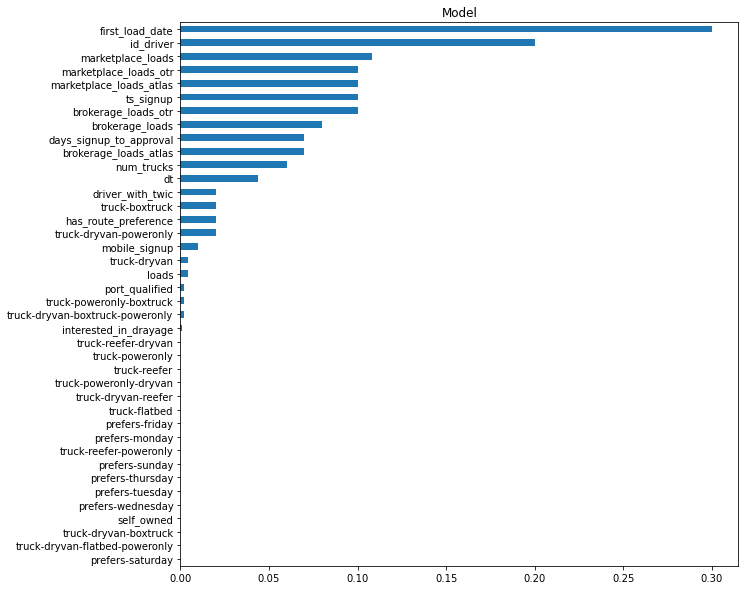

In [116]:
#perform adaboost and assess models
models = create_adaboost_models()
results, names = list(), list()
for name, model in models.items():
    scores = cv_adaboost_model(model, X_train, y_train, X_test, y_test)
    results.append(scores)
    names.append(name)
    print('>n_estimators:%s, Score: %.3f (%.3f)' % (name, mean(scores), std(scores)))
    feature_importance_adaboost_model(model, X_train)

In [ ]:
plt.plot()

# 8 - Neural Network

# 9 - Cross Validation

# 10 - Custom Model

In [17]:
clf = MLPClassifier()
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.9866338374956032